# Revisiting the ringdown of GW150914: paper plots

This Jupyter notebooks reproduces figures in our publication on _Revisiting the ringdown of GW150914_ (Isi & Farr, 2022).

_(See licensing information at the end of this file.)_

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import os
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotutils as pu
import ringdown as rd

sns.set_context('notebook')
sns.set_palette('colorblind')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Functions

In [3]:
Mref = 69
tM = Mref*rd.qnms.T_MSUN

t0Mref = 0.68
t0Ms = sort([t0Mref, 0] + [round(i,2) for i in arange(-1.0, 4.2, 0.2)])

In [21]:
def load_results(result_paths):
    all_results = {}
    for key, path in result_paths.items():
        all_results[key] = {}
        for sr in [2048]:
            all_results[key][sr] = {}
            for t0 in t0Ms:
                p = path.format(sr=sr, t0=t0, M=Mref)
                if os.path.exists(p):
                    try:
                        all_results[key][sr][t0] = az.from_netcdf(p)
                    except Exception:
                        print("Failed: %r" % p)
            if not all_results[key][sr]:
                del all_results[key][sr]
    return all_results

## Load data

If needed, procure data from Zenodo and untar. First, download data (this might take a while!):

In [35]:
# # ! wget https://zenodo.org/record/5965773/files/gwosc_4096s_16kHz_ds8_N0_gr.tar.gz
# # ! wget https://zenodo.org/record/5965773/files/gwosc_4096s_16kHz_ds8_N1_gr.tar.gz
# # ! wget https://zenodo.org/record/5965773/files/gwosc_4096s_16kHz_ds8_N1_ngr.tar.gz
# ! wget https://zenodo.org/record/5965773/files/imr_data.tar.gz

Then, check integrity of the data---the MD5 hashes of the posterior files should be:
```
MD5(gwosc_4096s_16kHz_ds8_N0_gr.tar.gz)= ef12c51b7dff2f48de91b8fd197185c2
MD5(gwosc_4096s_16kHz_ds8_N1_gr.tar.gz)= b2cee6b1d69e584a0c5c9af924aaecd6
MD5(gwosc_4096s_16kHz_ds8_N1_ngr.tar.gz)= 93a24d1678cf391b0194f6b6334b3dbe
MD5(imr_data.tar.gz)= 3be81edf8400622df398b54f0dbfe9ba
```

In [5]:
# ! openssl md5 gwosc_4096s_16kHz_ds8_N0_gr.tar.gz
# ! openssl md5 gwosc_4096s_16kHz_ds8_N1_gr.tar.gz
# ! openssl md5 gwosc_4096s_16kHz_ds8_N1_ngr.tar.gz
# ! openssl md5 imr_data.tar.gz

MD5(gwosc_4096s_16kHz_ds8_N0_gr.tar.gz)= ef12c51b7dff2f48de91b8fd197185c2
MD5(gwosc_4096s_16kHz_ds8_N1_gr.tar.gz)= b2cee6b1d69e584a0c5c9af924aaecd6
MD5(gwosc_4096s_16kHz_ds8_N1_ngr.tar.gz)= 93a24d1678cf391b0194f6b6334b3dbe
MD5(imr_data.tar.gz)= 3be81edf8400622df398b54f0dbfe9ba


Untar posterior data before loading below.

In [6]:
# ! tar xf gwosc_4096s_16kHz_ds8_N0_gr.tar.gz
# ! tar xf gwosc_4096s_16kHz_ds8_N1_gr.tar.gz
# ! tar xf gwosc_4096s_16kHz_ds8_N1_ngr.tar.gz
# ! tar xf imr_data.tar.gz

### Kerr overtone

In [22]:
result_paths = {
    '4096s16kHz': 'results/gwosc_4096s_16kHz/gw150914_gr_N1_sr{sr}_T0.20s_t0{t0:+.2f}_{M:.1f}Msun.nc',
}
all_results = load_results(result_paths)

Extract some useful info from the posteriors.

In [24]:
all_results_dfs = {}
for key, resdict in all_results.items():
    results_df = pd.DataFrame({})
    for sr, rs in resdict.items():
        for t0M, r in rs.items():
            x = r.posterior.A[:,:,0].values.flatten()
            y = r.posterior.A[:,:,1].values.flatten()
            ixs = random.choice(len(x), min(5000, len(x)), replace=False)
            df = pd.DataFrame({'$A_0$': x[ixs], '$A_1$': y[ixs], '$t_0/M$': t0M, 'srate': sr})
            results_df = results_df.append(df)
    all_results_dfs[key] = results_df

In [9]:
# NOTE: could just make this a single DF ...
cols = ['med', 'hi', 'lo', 'sigmas']

all_stats_dfs = {}

for key, resdict in all_results.items():
    stats_dfs = {sr: pd.DataFrame(columns=cols, dtype=float)
                for sr in resdict}
    for sr, rs in resdict.items():
        for t0M in t0Ms:
            if t0M in rs:
                x = rs[t0M].posterior.A[:,:,1].values.flatten()
                # compute symmetric 68% CI and std
                m_h_l = [quantile(x, q) for q in [0.5, 0.66, 0.34]]
                s = mean(x) / std(x)
                stats_dfs[sr].loc[t0M] = dict(zip(cols, m_h_l + [s]))
    all_stats_dfs[key] = stats_dfs

### Kerr fundamental

In [10]:
result_paths = {
    '4096s16kHz': 'gwosc_4096s_16kHz_ds8_N0_gr/gw150914_gr_N0_sr{sr}_T0.20s_t0{t0:+.2f}_{M:.1f}Msun.nc',
}
all_results_n0 = load_results(result_paths)

### Non-Kerr overtone

In [11]:
result_paths_ngr = {
    '4096s16kHz': 'gwosc_4096s_16kHz_ds8_N1_ngr/gw150914_ngr_N1_sr{sr}_T0.20s_t0{t0:+.2f}_{M:.1f}Msun.nc', 
}
all_results_ngr = load_results(result_paths_ngr)

In [12]:
all_results_ngr_dfs = {}
for key, resdict in all_results_ngr.items():
    results_df = pd.DataFrame({})
    for sr, rs in resdict.items():
        for t0M, r in rs.items():
            df1 = r.posterior.df[:,:,1].values.flatten()
            dtau1 = r.posterior.dtau[:,:,1].values.flatten()
            ixs = random.choice(arange(len(df1)), min(len(df1), 5000), replace=False)
            df = pd.DataFrame({r'$\delta f_1$': df1[ixs], r'$\delta \tau_1$': dtau1[ixs],
                               '$t_0/M$': t0M, 'srate': sr})
            results_df = results_df.append(df)
    all_results_ngr_dfs[key] = results_df

### IMR data

In [13]:
wfs = ['IMRPhenomPv2', 'SEOBNRv4ROM']
tpeaks = {k: loadtxt('imr_data/peaktime_H1_{}.txt'.format(k)) for k in wfs}

imr_remnant = loadtxt('imr_data/gw150914_gwtc1_imr_remnant_samples.txt')

truths = dict([
    ('m', 68.546371658688),
    ('chi', 0.692085186818)
])

In [14]:
_, tau = rd.qnms.get_ftau(69, 0.69, 1)
tauM = tau / tM

## Plotting

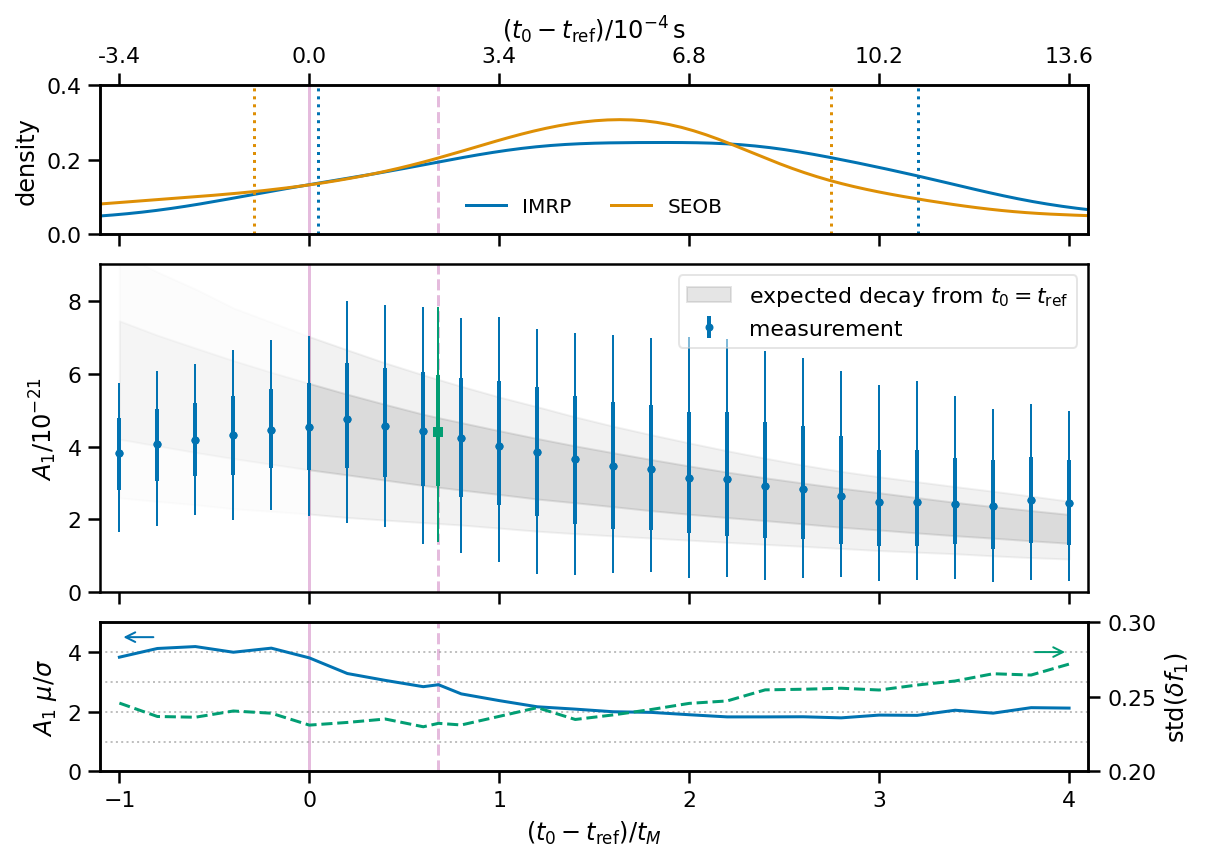

In [15]:
key = '4096s16kHz'
sr = 2048

# rescale amplitudes by the following factor for plotting
# (the factor of 2 brings this to the same definition used in Isi+2019)
ascale = 2*1E21

df = all_results_dfs[key].groupby('srate').get_group(sr)
results = all_results[key][sr]

fig = figure(figsize=(1.3*pu.fig_width,1.5*pu.fig_height))

ax1 = subplot2grid((4, 1), (1, 0), rowspan=2, fig=fig)
axlow = subplot2grid((4, 1), (3, 0), fig=fig)
axhigh = subplot2grid((4, 1), (0, 0), fig=fig)

axlower = axlow.twinx()
ax1b = axhigh.twiny()

# plot trendline draws
t = t0Ms
amps = ascale*results[0].posterior.A[:,:,1].values.flatten()
taus = results[0].posterior.tau[:,:,1].values.flatten()

c = 'gray'
label = r'expected decay from $t_0=t_{\rm ref}$'
ys = []
for i in random.choice(len(amps), 2000):
    tauM = taus[i] / tM
    ys.append(amps[i]*exp(-t/tauM))

ci_kws = {
    0.95: dict(alpha=0.1),
    0.68: dict(alpha=0.2, label=label),
}
for ci, kws in ci_kws.items():
    y_lo = quantile(ys, (1-ci)/2, axis=0)
    y_hi = quantile(ys, 1-(1-ci)/2, axis=0)
    ax1.fill_between(t[t>=0], y_hi[t>=0], y_lo[t>=0], color=c, **kws)
    ax1.fill_between(t[t<=0], y_hi[t<=0], y_lo[t<=0], color=c, alpha=kws['alpha']/4)

ci_kws = {
    0.95: dict(capthick=0, lw=1),
    0.68: dict(capthick=0, lw=2, label='measurement'),
}
for ci, kws in ci_kws.items():
    df_grouped = df.groupby(r'$t_0/M$')
    med = ascale*df_grouped.median()[r'$A_1$']
    lo = ascale*df_grouped.quantile((1-ci)/2)[r'$A_1$']
    hi = ascale*df_grouped.quantile(1-(1-ci)/2)[r'$A_1$']

    c = sns.color_palette()[0]
    ax1.errorbar(med.index, med, yerr=(med - lo, hi - med), fmt='.',
         capsize=4, c=c, label=kws.pop('label', None), **kws)
    if t0Mref in med:
        c = sns.color_palette()[2]
        ax1.errorbar([t0Mref], med[[t0Mref]], yerr=(med[[t0Mref]] - lo[[t0Mref]],
                     fmt='s', capsize=4, c=c, markersize=4, **kws)

ax1.set_ylim(0, ascale*4.5E-21);

ax1b.set_xticks(ax1.get_xticks());
ax1b.set_xlim(ax1.get_xlim());
ax1b.set_xticklabels(['{:.1f}'.format(t) for t in ax1.get_xticks()*tM / 1E-4]);

axlow.set_xlabel(r'$(t_0 - t_{\rm ref})/t_M$');
ax1b.set_xlabel(r'$(t_0 - t_{\rm ref})/10^{-4}\,\mathrm{s}$');

ax1.set_ylabel(r'$A_1/10^{-21}$');
axlow.set_ylabel(r'$A_1~\mu/\sigma$');

ax1.legend(framealpha=0.5);

# sigmas
axlow.plot(med.index, med/(0.5*(hi-lo)));
for s in [1, 2, 3, 4]:
    axlow.axhline(s, lw=1, c='gray', ls=':', alpha=0.5, zorder=-1)

c = sns.color_palette()[4]
for ax in [ax1, axlow, axhigh]:
    ax.axvline(0, c=c, alpha=0.5, zorder=-100)
    if t0Mref in med:
        ax.axvline(t0Mref, c=c, ls='--', alpha=0.5, zorder=-100)
axlow.set_ylim(0, 5);

# tpeaks
wfs = ['IMRPhenomPv2', 'SEOBNRv4ROM']
for i, wf in enumerate(wfs):
    t = (tpeaks[wf] - 1126259462.423) / tM
    sns.kdeplot(t, ax=axhigh, label=wf[:4])
    
    c = sns.color_palette()[i]
    m, l, h = [percentile(t, p) for p in [50, (100-68)/2, 100-(100-68)/2]]
    for cl in [h, l]:
        axhigh.axvline(cl, c=c, ls=':')
axhigh.legend(ncol=2, loc='lower center', frameon=False, fontsize=10)

for ax in [ax1, ax1b, axhigh]:
    ax.set_xlim(-1.1, 4.1);
    
# Beyond Kerr
c_df1 = sns.color_palette()[2]
df_ngr = all_results_ngr_dfs[key].groupby('srate').get_group(sr)
stds = df_ngr.groupby(r'$t_0/M$').std()[r'$\delta f_1$']
axlower.plot(stds, c=c_df1, ls='--');
axlower.set_ylabel(r'$\mathrm{std}(\delta f_1)$')
# axlower.grid(axis='y', ls=':')
axlower.set_yticks([0.25, 0.27])

axhigh.set_ylim(0, 0.4);
axhigh.set_xticklabels([]);
axhigh.set_ylabel('density');

axlow.annotate('', (-1,4.5), xytext=(-0.8,4.5), 
               arrowprops=dict(arrowstyle='->',lw=1,color=sns.color_palette()[0]));
axlower.annotate('', (4,0.28), xytext=(3.8,0.28), arrowprops=dict(arrowstyle='->',lw=1,color=c_df1));

axlower.set_yticks([0.2, 0.25, 0.3])
axlower.set_ylim([0.2, 0.3])

for ax in [ax1, axhigh]:
    ax.set_xticks(axlow.get_xticks())
    ax.set_xticklabels([])

for ax in [ax1, axhigh, axlow]:
    ax.set_xlim(-1.1, 4.1);

savefig('amp_vs_time.pdf', bbox_inches='tight')

In [16]:
prior = 1/5E-21
df = all_results_dfs[key].groupby('srate').get_group(sr)

posteriors = pd.Series(dtype=float64)
for t0M, dfg in df.groupby(r'$t_0/M$'):
    kde = gaussian_kde(dfg[r'$A_1$'].values)
    posteriors[t0M] = kde(0)[0]
bfs_n0_vs_n1 = posteriors/prior

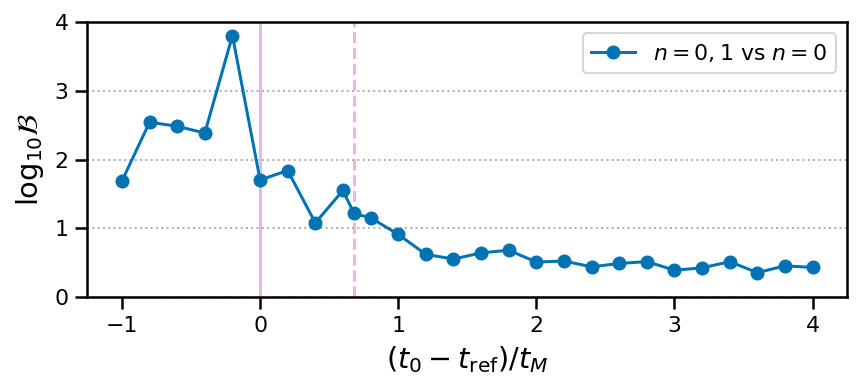

In [33]:
figure(figsize=(pu.fig_width, pu.fig_height*0.6))
plot(log10(1/bfs_n0_vs_n1), marker='o', label=r'$n=0,1$ vs $n=0$')
xlabel(r'$(t_0-t_{\rm ref})/t_M$', fontsize=pu.fs_label)
ylabel(r'$\log_{10} \mathcal{B}$', fontsize=pu.fs_label);
ylim(0, 4);
grid(axis='y', ls=':')
c = sns.color_palette()[4]
axvline(0, c=c, alpha=0.5, zorder=-100)
if t0Mref in bfs_n0_vs_n1:
    axvline(t0Mref, c=c, ls='--', alpha=0.5, zorder=-100)
legend();
savefig('bf.pdf', bbox_inches='tight')

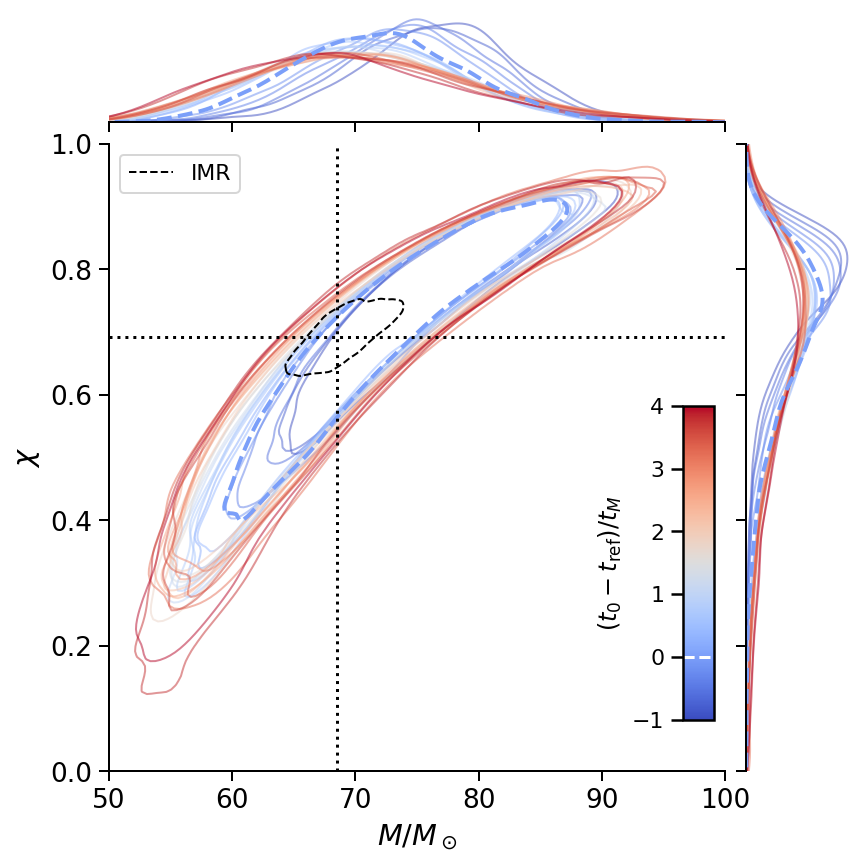

In [18]:
df = all_results['4096s16kHz'][2048]

cmap = plt.cm.coolwarm
t = list(df.keys())
norm = matplotlib.colors.Normalize(vmin=min(t), vmax=max(t));

g = None
for i, t0M in enumerate([ti for ti in t if ti!=0]+[0]):
    lw = 2 if t0M in [0, 0.72] else 1
    ls = '--' if t0M == 0 else '-'
    a = 1 if t0M == 0 else 0.5
    c = cmap(norm(t0M))[:-1]
    g = pu.plot_mchi(df[t0M], g=g, points=False, levels=[0.9,], color=c,
                  lws=[lw,], alpha=a, ls=ls)
g.ax_joint.axvline(truths['m'], ls=':', c='k')
g.ax_joint.axhline(truths['chi'], ls=':', c='k')

g = pu.plot_mchi(x=imr_remnant[0], y=imr_remnant[1],
                 color='k', marginals=False,
                 ls='--', points=False, levels=[0.9,], g=g,
                 label='IMR')
legend(loc='upper left');

ax = gca()

# create mass colorbar
cm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
cm.set_array([])

cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=(0, -0.4, 1, 1),
                      bbox_transform=ax.transAxes)
cb = plt.colorbar(cm, orientation='vertical', cax=cbaxes)
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')
cb.ax.yaxis.tick_left()
cb.ax.yaxis.set_label_position("left")
cb.ax.set_ylabel(r'$(t_0 - t_{\rm ref})/t_M$')

cb.ax.axhline(0, c='w', ls='--')

savefig('mchi_n1.pdf', bbox_inchest='tight')

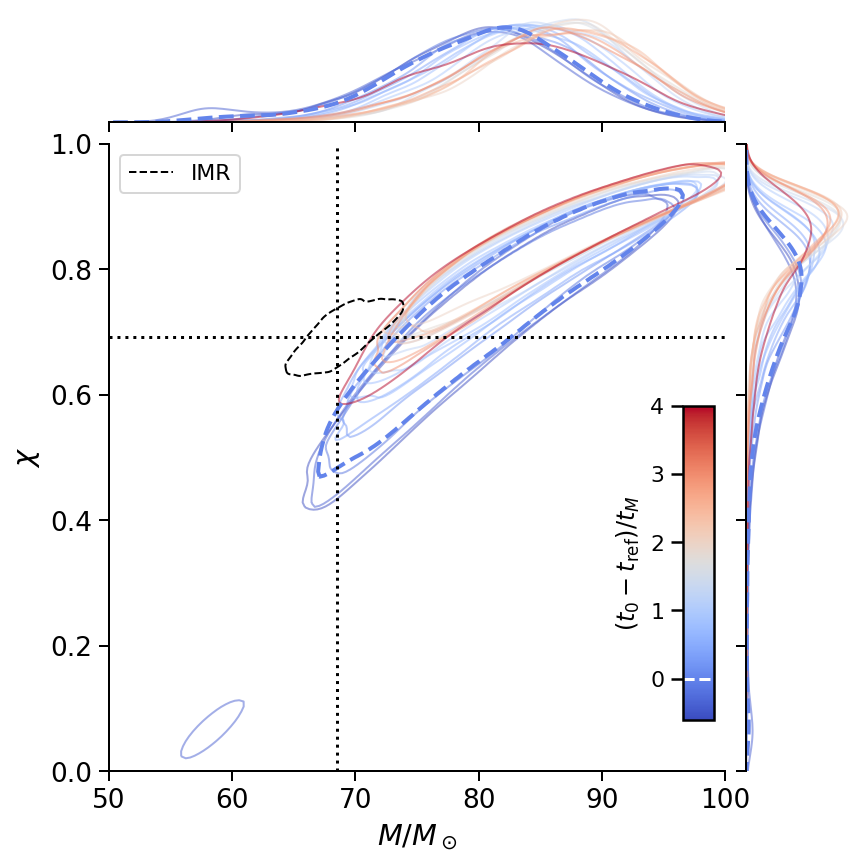

In [19]:
df = all_results_n0['4096s16kHz'][2048]

cmap = plt.cm.coolwarm
t = list(df.keys())
norm = matplotlib.colors.Normalize(vmin=min(t), vmax=max(t));

g = None
for i, t0M in enumerate([ti for ti in t if ti!=0]+[0]):
    lw = 2 if t0M in [0, 0.72] else 1
    ls = '--' if t0M == 0 else '-'
    a = 1 if t0M == 0 else 0.5
    c = cmap(norm(t0M))[:-1]
    g = pu.plot_mchi(df[t0M], g=g, points=False, levels=[0.9,], color=c,
                  lws=[lw,], alpha=a, ls=ls)
g.ax_joint.axvline(truths['m'], ls=':', c='k')
g.ax_joint.axhline(truths['chi'], ls=':', c='k')

g = pu.plot_mchi(x=imr_remnant[0], y=imr_remnant[1],
          color='k', marginals=False,
          ls='--', points=False, levels=[0.9,], g=g,
         label='IMR')
legend(loc='upper left');

# create mass colorbar
ax = gca()
cm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
cm.set_array([])

cbaxes = inset_axes(ax, width="5%", height="50%", 
                    bbox_to_anchor=(0, -0.4, 1, 1),
                    bbox_transform=ax.transAxes)
cb = plt.colorbar(cm, orientation='vertical', cax=cbaxes)
cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')
cb.ax.yaxis.tick_left()
cb.ax.yaxis.set_label_position("left")
cb.ax.set_ylabel(r'$(t_0 - t_{\rm ref})/t_M$')

cb.ax.axhline(0, c='w', ls='--')

savefig('mchi_n0.pdf', bbox_inchest='tight')

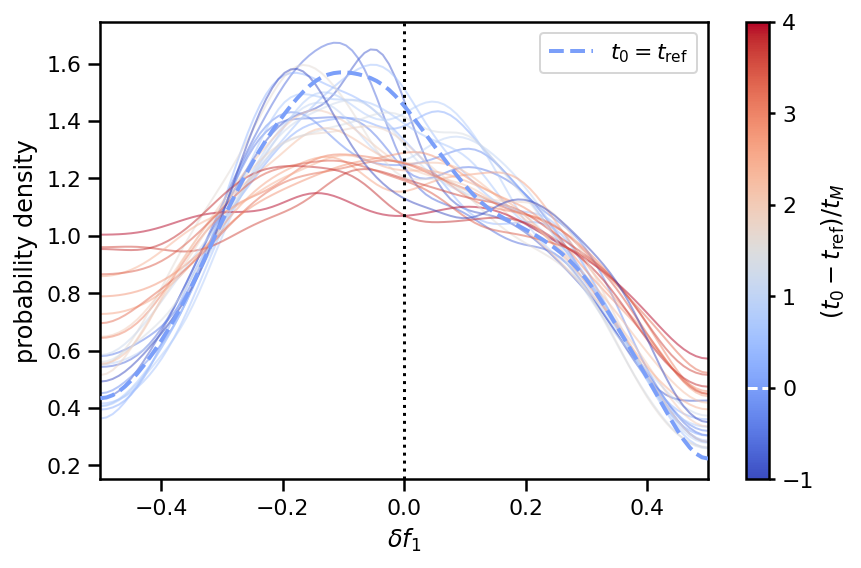

In [20]:
rs = all_results_ngr['4096s16kHz'][2048]

figure(figsize=pu.figsize_column)

cmap = plt.cm.coolwarm
t = list(rs.keys())
norm = matplotlib.colors.Normalize(vmin=min(t), vmax=max(t));

ts = set(sort(list(rs.keys())[::1] + [0, t0Mref]))
for i, t0M in enumerate(ts):
    lw = 2 if t0M in [0, 0.72] else 1
    c = cmap(norm(t0M))[:-1]
    pts = rs[t0M].posterior.df[:,:,1].values.flatten()
    kde = rd.Bounded_1d_kde(pts, xlow=-0.5, xhigh=0.5)
    x = linspace(-0.5, 0.5, 100)
    plot(x, kde(x), c=c, lw=lw, zorder=100 if t0M==0 else None,
         alpha=1 if t0M==0 else 0.5, ls='--' if t0M==0 else '-',
         label=r'$t_0=t_{\rm ref}$' if t0M==0 else None)
axvline(0, ls=':', c='k')
legend(loc='upper right', ncol=1)
xlim(-0.5, 0.5);
xlabel(r'$\delta f_1$');
ylabel('probability density');

ax = gca()
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)

cbar.ax.tick_params('y', length=3, which='major')
cbar.set_label(r'$\left(t_0 - t_{\rm ref}\right)/t_M$', fontsize=12,
               labelpad=2.5)

cbar.ax.axhline(0, c='w', ls='--')

savefig('df1.pdf', bbox_inches='tight')

## License

Copyright 2022
Maximiliano Isi <max.isi@ligo.org>

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston,
MA 02110-1301, USA.